In [1]:
from qaravan.core import two_local_circ, TFI, RunContext
from qaravan.applications import brickwall_skeleton
from plotting import set_style
from qaravan.tensorQ import StatevectorSim
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the problem
n = 4
ham = TFI(n)
true_ge, true_gs = ham.ground()  # uses Lanczos-based ED
print(f"True ground state energy: {true_ge}")

ham_mat = ham.matrix(dense=True) # PyTorch doesn't support sparse matrices yet
ham_mat = torch.tensor(ham_mat, dtype=torch.complex128)  # convert to PyTorch for AD

def circuit_energy(params, skeleton, ham_mat): 
    circ = two_local_circ(skeleton, params)
    sim = StatevectorSim(circ, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return (ansatz_sv.conj() @ ham_mat @ ansatz_sv).real

True ground state energy: [-0.75]


In [3]:
# set up ansatz and optimizer 
num_layers = 1
skeleton = brickwall_skeleton(n, num_layers)  # structure of the ansatz circuit
params = torch.nn.Parameter(torch.randn(15*len(skeleton)))
optimizer = torch.optim.Adam([params], lr=0.05)

# set up RunContext for logging, checkpointing, and stopping
context = RunContext(
    progress_interval=10,
    max_iter=10000,
    checkpoint_file="checkpoint.pickle",
    checkpoint_interval=100,
    resume=False,
    convergence_check=True,
    stop_ratio=1e-8
)

# initialize the state of the run
cost_list = []
run_state = {
    "cost_list": cost_list,
    "step": context.step
}

while True:
    cost = circuit_energy(params, skeleton, ham_mat)
    cost_list.append(cost.item())
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Update run state
    run_state["step"] += 1
    run_state["cost_list"] = cost_list

    # Let RunContext handle logging, checkpointing, and stopping
    if context.step_update(run_state):
        print(f"Terminating at step {run_state['step']} with cost {cost_list[-1]}")
        break

Step 10 at 2025-09-30T15:57:52 with cost -0.41539884996171766
Step 20 at 2025-09-30T15:57:52 with cost -0.540323321825225
Step 30 at 2025-09-30T15:57:52 with cost -0.6935748024695461
Step 40 at 2025-09-30T15:57:52 with cost -0.7346924916754157
Step 50 at 2025-09-30T15:57:52 with cost -0.7458318225148691
Step 60 at 2025-09-30T15:57:52 with cost -0.7489310759425744
Step 70 at 2025-09-30T15:57:52 with cost -0.7497064883152864
Step 80 at 2025-09-30T15:57:52 with cost -0.7498621691109812
Step 90 at 2025-09-30T15:57:52 with cost -0.7499161071800399
Step 100 at 2025-09-30T15:57:52 with cost -0.749954086951071
[Checkpoint saved at step 100 in file checkpoint.pickle]
Step 110 at 2025-09-30T15:57:52 with cost -0.7499791609689762
Step 120 at 2025-09-30T15:57:52 with cost -0.7499892923137453
Step 130 at 2025-09-30T15:57:52 with cost -0.7499942485579889
Plateau detected with cost -0.7499942485579889 at step 130
Terminating at step 130 with cost -0.7499942485579889


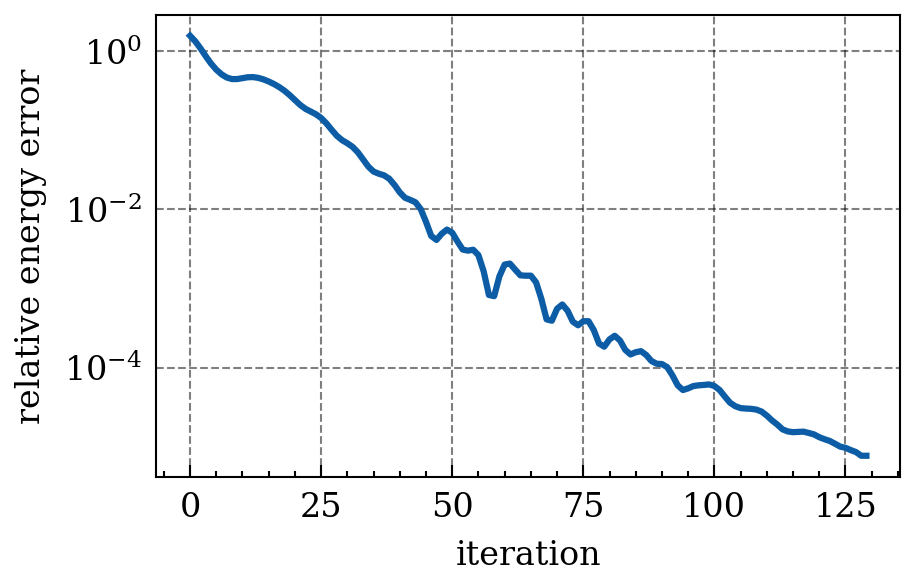

In [4]:
rel_energy_err = [np.abs(c-true_ge)/np.abs(true_ge) for c in cost_list]

set_style()
fig, ax = plt.subplots(figsize=(3.2,2))
ax.plot(rel_energy_err, label="Relative energy error", color="C0")
ax.set_xlabel("iteration")
ax.set_ylabel("relative energy error")
ax.set_yscale("log")